In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    path_andrey = '/Home/siv30/wad005/master/GRB/MATLAB/andrey_mezentsev/'

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    path_andrey = '/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/'
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example
%matplotlib inline

# GRB181222B

In [ ]:
binsize = 0.002
bins_181222B = np.arange(-0.512,1.058,binsize)

In [ ]:
tlagg_asim = -0.44

df_asim = harvest_data(fn='2018_12_22_20_11_36',T0='2018-12-22T20:11:36.576')
df_asim['tus']+=tlagg_asim
tus_asim = df_asim['tus'].to_numpy()
tus_asim = tus_asim[np.searchsorted(tus_asim,-2):]
#bin tus_asim by the bins specified by KW

In [ ]:
T0 = datetime.fromisoformat('2018-12-22T20:11:36.576') + timedelta(seconds=-0.44)
print(T0)

In [ ]:
#importing KW LC

kw_fn = 'GRB181222B_2ms.txt'
kw_df = pd.read_csv(kw_lc_path+kw_fn,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float32), kw_df["Tf"].to_numpy(dtype=np.float32),kw_df["G1"].to_numpy(dtype=np.float32), kw_df["G2"].to_numpy(dtype=np.float32), kw_df["G3"].to_numpy(dtype=np.float32)
kw_df.head()

## FERMI extraction

In [ ]:
GRB_id = "GRB181222B"
bn='bn181222841' # GRB id for Fermi
data_dir = path_FERMI_dir + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 311.7605, 24.5163  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting


#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function


In [ ]:
unit = all_dets[idx_sort_angsep][5] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_b0 = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_b0 = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_b0 = TTE.open(fn_tte_b0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte_b0.to_phaii(bin_by_time,binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,4e4)
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-0.5,1)
lcplot.ax.set_title(f'GRB181222B FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
#plt.savefig(fname='/Users/andreas/phys/master/GRB/pyplots/GRB211211A_FERMI_LC.png')
plt.show()

In [ ]:
i_fermi_b0, j_fermi_b0 = np.searchsorted(tte_b0.data.time,-0.512),np.searchsorted(tte_b0.data.time,1.058)
fermi_tus = tte_b0.data.time[i_fermi_b0:j_fermi_b0] + 0.0008 #tlagg
hist_fermi_b0 = np.histogram(fermi_tus,bins_181222B)
fermi_counts_b0,fermi_edges_b0 = hist_fermi_b0[0],hist_fermi_b0[1]
plt.step(fermi_edges_b0[:-1],fermi_counts_b0)
plt.show()

In [ ]:
unit = all_dets[idx_sort_angsep][0] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_naI = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_naI = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_naI = TTE.open(fn_tte_naI)

i_fermi_naI, j_fermi_naI = np.searchsorted(tte_naI.data.time,-0.512),np.searchsorted(tte_naI.data.time,1.058)
fermi_tus_naI = tte_naI.data.time[i_fermi_naI:j_fermi_naI] + 0.0008 #tlagg
hist_fermi_naI = np.histogram(fermi_tus_naI,bins_181222B)
fermi_counts_naI,fermi_edges_naI = hist_fermi_naI[0],hist_fermi_naI[1]
plt.step(fermi_edges_naI[:-1],fermi_counts_naI)
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))

binsize = 0.002
intervals = [[0.0, 0.512], [0.128, 0.256]]

ax_height = 1 / 4
ax_width = 0.27

ax1 = fig.add_axes([0.1, 1 - ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 400))
ax2 = fig.add_axes([0.1, 1 - 2 * ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 200))
ax3 = fig.add_axes([0.1, 1 - 3 * ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 150))
ax4 = fig.add_axes([0.1, 1 - 4 * ax_height, ax_width, ax_height], ylim=(0, 150))

# set the yticks for each subplot
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])

kw_dt = np.round(np.diff(kw_bin_lo), 3)
jx_kw = np.where(kw_dt > binsize)[0][0] + 35  # finding first entry where the binsize increases
kw_counts_1 = G1[:jx_kw] + G2[:jx_kw] + G3[:jx_kw]
ax1.step(x=kw_bin_lo[:jx_kw], y=kw_counts_1, where='pre', label='KW\nG1,G2,G3', color='black')
ax1.set_yticks([0, 100, 200, 300, 400])
ax1.set_ylabel(f'cnts  /  {round(binsize * 1e3)} / 16 ms')
ax1.vlines(x=intervals[0][0], ymin=0, ymax=400, color='black', linestyle='--')
ax1.vlines(x=intervals[0][1], ymin=0, ymax=400, color='black', linestyle='--')
ax1.vlines(x=intervals[1][0], ymin=0, ymax=400, color='red', linestyle='--')
ax1.vlines(x=intervals[1][1], ymin=0, ymax=400, color='red', linestyle='--')
# ----------------------------------------------------------------------------------
hist = np.histogram(tus_asim, np.arange(-0.512, 1.058, 0.002))
asim_counts, asim_edges = hist[0], hist[1]
ax2.step(asim_edges[:-1], asim_counts, label='HED\ninc. bak', color='black')
ax2.set_yticks([0, 50, 100, 150])
ax2.set_ylabel(f'cnts  /  {round(binsize * 1e3)} ms')
ax2.vlines(x=intervals[0][0], ymin=0, ymax=200, color='black', linestyle='--')
ax2.vlines(x=intervals[0][1], ymin=0, ymax=200, color='black', linestyle='--')
ax2.vlines(x=intervals[1][0], ymin=0, ymax=200, color='red', linestyle='--')
ax2.vlines(x=intervals[1][1], ymin=0, ymax=200, color='red', linestyle='--')
# ---------------------------------------------------------------------------------
ax3.step(fermi_edges_b0[:-1], fermi_counts_b0, label='FERMI BG0\ninc. bak', color='black')
ax3.set_yticks([0, 50, 100])
ax3.set_ylabel(f'cnts  /  {round(binsize * 1e3)} ms')
ax3.vlines(x=intervals[0][0], ymin=0, ymax=150, color='black', linestyle='--')
ax3.vlines(x=intervals[0][1], ymin=0, ymax=150, color='black', linestyle='--')
ax3.vlines(x=intervals[1][0], ymin=0, ymax=150, color='red', linestyle='--')
ax3.vlines(x=intervals[1][1], ymin=0, ymax=150, color='red', linestyle='--')
# -------------------------------------------------------------------------------
ax4.step(fermi_edges_naI[:-1], fermi_counts_naI, label='FERMI NaI\ninc. bak', color='black')
ax4.set_yticks([0, 50, 100])
ax4.set_ylabel(f'cnts  /  {round(binsize * 1e3)} ms')
ax4.vlines(x=intervals[0][0], ymin=0, ymax=150, color='black', linestyle='--')
ax4.vlines(x=intervals[0][1], ymin=0, ymax=150, color='black', linestyle='--')
ax4.vlines(x=intervals[1][0], ymin=0, ymax=150, color='red', linestyle='--')
ax4.vlines(x=intervals[1][1], ymin=0, ymax=150, color='red', linestyle='--')
#-----------------------------------------------------------------------------

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 181222B',ha='center',va='top',x=0.232,y=1.02)
plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/stacked_LC/GRB181222B.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()

# GRB 190206A

In [ ]:
bins_190206A = np.arange(-0.512,0.512,0.002)
binsize=0.002
tlagg_asim = -0.2955
#T0_asim = datetime.fromisoformat('2020-12-27T15:14:06.853667') + timedelta(seconds=-0.531)
#print(T0_asim)
asimData = pd.read_csv(path_andrey + 'GRB190206A.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
asim_tus = asimData['tus'].to_numpy()
asimData.head()

In [ ]:
kw_filename = "GRB190206A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>2*binsize)[0][0]

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G2+G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

In [ ]:
fig = plt.figure(figsize=(16, 8))

binsize = 0.002
intervals = [0.0, 0.064]

ax_height = 1 / 4
ax_width = 0.27

ax1 = fig.add_axes([0.1, 1 - ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 400))
ax2 = fig.add_axes([0.1, 1 - 2 * ax_height, ax_width, ax_height], ylim=(0, 400))

ax1.step(x=kw_lc.bin_lo, y=kw_lc.counts, where='pre', label='KW\nG2,G3', color='black')
ax1.set_yticks([0, 100, 200, 300, 400])
ax1.set_ylabel(f'cnts  /  {round(binsize * 1e3)}')
ax1.vlines(x=intervals[0], ymin=0, ymax=400, color='black', linestyle='--')
ax1.vlines(x=intervals[1], ymin=0, ymax=400, color='black', linestyle='--')
ax1.set_xlim(-0.064, 0.128)
ax1.set_xticks([-0.064, 0, 0.128])
ax1.legend()

# ----------------------------------------------------------------------------------
hist = np.histogram(asim_tus, kw_lc.bin_lo)
asim_counts, asim_edges = hist[0], hist[1]
ax2.step(asim_edges[:-1], asim_counts, label='HED\ninc. bak', color='black')
ax2.set_yticks([0, 100, 200, 300])
ax2.set_ylabel(f'cnts  /  {round(binsize * 1e3)} ms')
ax2.vlines(x=intervals[0], ymin=0, ymax=400, color='black', linestyle='--')
ax2.vlines(x=intervals[1], ymin=0, ymax=400, color='black', linestyle='--')
ax2.set_xlim(-0.064, 0.128)
ax2.set_xticks([0.00, 0.064,0.128])
ax2.legend()


plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 190206A',ha='center',va='top',x=0.232,y=1.02)
plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/stacked_LC/GRB190206A.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()

# GRB 190305A

In [ ]:
binsize=0.016
bins_190305A = np.arange(-0.512,2,binsize)
tlagg_asim = 0.5150625
#T0_asim = datetime.fromisoformat('2020-12-27T15:14:06.853667') + timedelta(seconds=-0.531)
#print(T0_asim)
asimData = pd.read_csv(path_andrey + 'GRB190305A.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
tus_asim = asimData['tus'].to_numpy()
asimData.head()

In [ ]:
plt.hist(tus_asim,bins_190305A)
plt.show()
T0 = datetime.fromisoformat('2019-03-05T13:05:20.355640') + timedelta(seconds=tlagg_asim)
print(T0)

In [ ]:
kw_filename = "GRB190305A_16ms.txt"
kw_file = kw_lc_path + kw_filename

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)


i_stop_kw = np.searchsorted(kw_bin_lo,1.792)

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G2+G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()


bins_190305A = np.append(np.round(kw_lc.bin_lo,3),kw_lc.bin_hi[-1])

In [ ]:
fig = plt.figure(figsize=(16, 8))

binsize=0.002
intervals = [0.768,1.280]

ax_height = 1 / 4
ax_width = 0.27

ax1 = fig.add_axes([0.1, 1 - ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 1000))
ax2 = fig.add_axes([0.1, 1 - 2 * ax_height, ax_width, ax_height], ylim=(0, 300))

ax2.set_yticks([])

ax1.step(x=kw_lc.bin_lo,y=kw_lc.counts,where='pre',label='KW\nG2,G3',color='black')
ax1.set_yticks([0,250,500,750])
ax1.set_ylabel(f'cnts  /  16 ms')
ax1.vlines(x=intervals[0],ymin=0,ymax=1000,color='black',linestyle='--')
ax1.vlines(x=intervals[1],ymin=0,ymax=1000,color='black',linestyle='--')
#----------------------------------------------------------------------------------
hist = np.histogram(tus_asim,bins=bins_190305A)
asim_counts, asim_edges = hist[0],hist[1]
ax2.step(asim_edges[:-1],asim_counts,label='HED',color='black')
ax2.set_yticks([0,100,200])
ax2.set_ylabel(f'cnts  /  16 ms')
ax2.vlines(x=intervals[0],ymin=0,ymax=300,color='black',linestyle='--')
ax2.vlines(x=intervals[1],ymin=0,ymax=300,color='black',linestyle='--')

ax1.legend()
ax2.legend()

plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 190305A',ha='center',va='top',x=0.232,y=1.02)
#plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/stacked_LC/GRB190305A.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
binsize = 0.002
tus_asim = asimData['tus'].to_numpy()
bins=np.round(np.arange(min(tus_asim), max(tus_asim) + binsize, binsize),3)
counts, edges = np.histogram(tus_asim, bins=bins)
Ti, Tf = edges[:-1], edges[1:]
df_export = pd.DataFrame({'Ti':Ti, 'Tf':Tf, 'Counts': counts})
df_export.to_csv(f'/Users/andreas/phys/master/GRB/xspec/ASIM/light_curves/GRB190305A_HED_{binsize*1e3:.0f}ms',index_label=False,index=False)
plt.step(edges[:-1],counts)
plt.show()

# GRB 190606A

In [10]:
binsize=0.016
tlagg_asim = -0.5366225269343781
asimData = pd.read_csv(path_andrey+'GRB190606A.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
tus_asim = asimData['tus'].to_numpy()
asimData.head()

,tus,dau,det,typ,erg
0,-1.047156,0,0,0,57
1,-1.046935,2,2,0,80
2,-1.046935,0,1,0,1108
3,-1.046296,3,1,0,57
4,-1.046173,3,0,0,1327


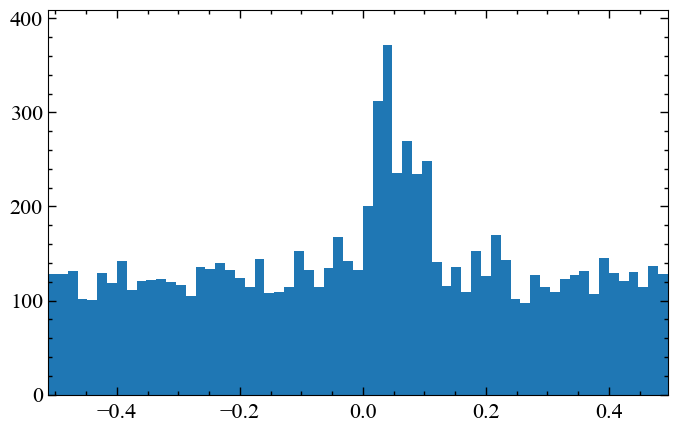

2019-06-06 01:55:06.781982


In [11]:
plt.hist(tus_asim,np.arange(-0.512,0.512,binsize))
plt.show()
T0 = datetime.fromisoformat('2019-06-06T01:55:07.318605') + timedelta(seconds=tlagg_asim)
print(T0)

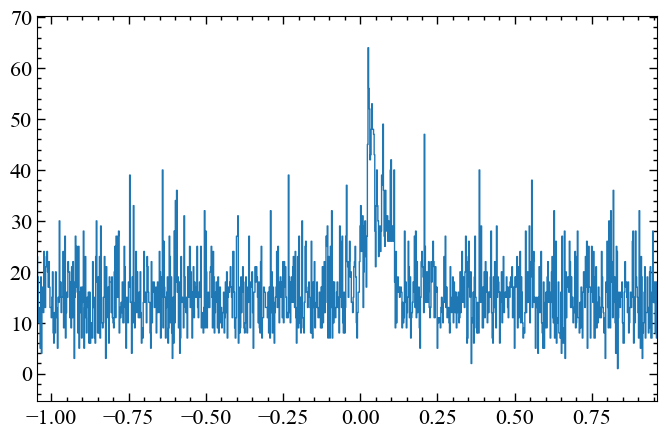

In [13]:
binsize = 0.002
tus_asim = asimData['tus'].to_numpy()
bins=np.round(np.arange(min(tus_asim), max(tus_asim) + binsize, binsize),3)
counts, edges = np.histogram(tus_asim, bins=bins)
Ti, Tf = edges[:-1], edges[1:]
df_export = pd.DataFrame({'Ti':Ti, 'Tf':Tf, 'Counts': counts})
df_export.to_csv(f'/Users/andreas/phys/master/GRB/xspec/ASIM/light_curves/GRB190606A_HED_{binsize*1e3:.0f}ms',index_label=False,index=False)
plt.step(edges[:-1],counts)
plt.show()

In [ ]:
kw_filename = "GRB190606A_16ms.txt"
kw_file = kw_lc_path + kw_filename

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)


i_stop_kw = np.searchsorted(kw_bin_lo,0.512)

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G2+G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()


bins_190606A = np.append(np.round(kw_lc.bin_lo,3),kw_lc.bin_hi[-1])

In [ ]:
GRB_id = "GRB190606A"
bn='bn190606080' # GRB id for Fermi
data_dir = path_FERMI_dir + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v02.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 76.561,-0.638  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))

In [ ]:
unit = all_dets[idx_sort_angsep][1] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_b0 = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_b0 = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_b0 = TTE.open(fn_tte_b0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte_b0.to_phaii(bin_by_time,binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,4e4)
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (asim_edges[0],asim_edges[-1])
lcplot.ax.set_title(f'GRB181222B FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
#plt.savefig(fname='/Users/andreas/phys/master/GRB/pyplots/GRB211211A_FERMI_LC.png')
plt.show()

In [ ]:
i_fermi_b0, j_fermi_b0 = np.searchsorted(tte_b0.data.time,-0.512),np.searchsorted(tte_b0.data.time,0.512)
fermi_tus = tte_b0.data.time[i_fermi_b0:j_fermi_b0]-0.042
hist_fermi_b0 = np.histogram(fermi_tus,bins_190606A)
fermi_counts_b0,fermi_edges_b0 = hist_fermi_b0[0],hist_fermi_b0[1]
plt.step(fermi_edges_b0[:-1],fermi_counts_b0)
plt.show()

In [ ]:
unit = all_dets[idx_sort_angsep][0] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_naI = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_naI = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_naI = TTE.open(fn_tte_naI)

i_fermi_naI, j_fermi_naI = np.searchsorted(tte_naI.data.time,-0.512),np.searchsorted(tte_naI.data.time,1.058)
fermi_tus_naI = tte_naI.data.time[i_fermi_naI:j_fermi_naI]-0.042
hist_fermi_naI = np.histogram(fermi_tus_naI,bins_190606A)
fermi_counts_naI,fermi_edges_naI = hist_fermi_naI[0],hist_fermi_naI[1]
plt.step(fermi_edges_naI[:-1],fermi_counts_naI)
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))

intervals = [0.00,0.064]

ax_height = 1 / 4
ax_width = 0.27

ax1 = fig.add_axes([0.1, 1 - ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 250))
ax2 = fig.add_axes([0.1, 1 - 2 * ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 450))
ax3 = fig.add_axes([0.1, 1 - 3 * ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 400))
ax4 = fig.add_axes([0.1, 1 - 4 * ax_height, ax_width, ax_height], ylim=(0, 400))


ax1.step(x=kw_lc.bin_lo,y=kw_lc.counts,where='pre',label='KW\nG2,G3',color='black')
ax1.set_yticks([0,50,100,150,200,250])
ax1.set_ylabel(f'cnts  /  16 ms')
ax1.vlines(x=intervals[0],ymin=0,ymax=250,color='black',linestyle='--')
ax1.vlines(x=intervals[1],ymin=0,ymax=250,color='black',linestyle='--')
#----------------------------------------------------------------------------------
hist = np.histogram(tus_asim,bins=bins_190606A)
asim_counts, asim_edges = hist[0],hist[1]
ax2.step(asim_edges[:-1],asim_counts,label='HED',color='black')
ax2.set_yticks([0,100,200,300,400])
ax2.set_ylabel(f'cnts  /  16 ms')
ax2.vlines(x=intervals[0],ymin=0,ymax=450,color='black',linestyle='--')
ax2.vlines(x=intervals[1],ymin=0,ymax=450,color='black',linestyle='--')
#---------------------------------------------------------------------------------
ax3.step(fermi_edges_b0[:-1],fermi_counts_b0,label='FERMI BG0\ninc. bak',color='black')
ax3.set_yticks([0,100,200,300])
ax3.set_ylabel(f'cnts  / 16 ms')
ax3.vlines(x=intervals[0],ymin=0,ymax=400,color='black',linestyle='--')
ax3.vlines(x=intervals[1],ymin=0,ymax=400,color='black',linestyle='--')
#-------------------------------------------------------------------------------
ax4.step(fermi_edges_naI[:-1],fermi_counts_naI,label='FERMI NaI\ninc. bak',color='black')
ax4.set_yticks([0,100,200,300])
ax4.set_ylabel(f'cnts  / 16 ms')
ax4.vlines(x=intervals[0],ymin=0,ymax=400,color='black',linestyle='--')
ax4.vlines(x=intervals[1],ymin=0,ymax=400,color='black',linestyle='--')
#-----------------------------------------------------------------------------

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 190606A',ha='center',va='top',x=0.232,y=1.02)
plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/stacked_LC/GRB190606A.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()

# GRB 200521A

In [14]:
binsize=0.016
tlagg_asim = -0.814
asimData = pd.read_csv(path_andrey + 'GRB200521A.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
asim_tus = asimData['tus'].to_numpy()
asimData.head()

,tus,dau,det,typ,erg
0,-0.961473,1,2,0,368
1,-0.960743,1,2,0,75
2,-0.960506,1,1,0,917
3,-0.960242,3,0,0,89
4,-0.959868,3,2,0,812


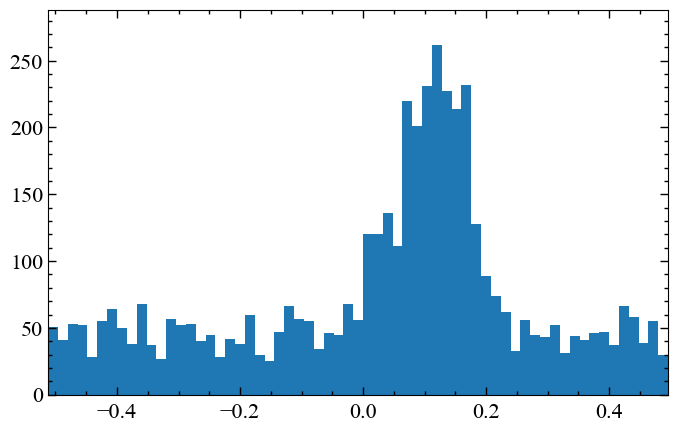

2020-05-21 12:16:39.630360


In [16]:
plt.hist(asim_tus,np.arange(-0.512,0.512,binsize))
plt.show()
T0 = datetime.fromisoformat('2020-05-21T12:16:40.444360') + timedelta(seconds=tlagg_asim)
print(T0)

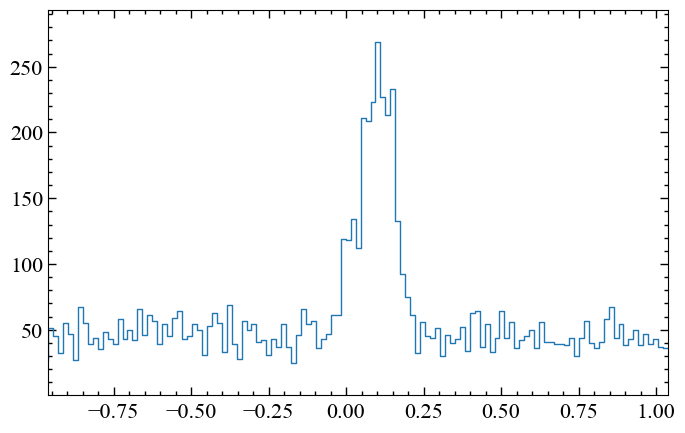

In [18]:
binsize = 0.016
tus_asim = asimData['tus'].to_numpy()
bins=np.round(np.arange(min(tus_asim), max(tus_asim) + binsize, binsize),3)
counts, edges = np.histogram(tus_asim, bins=bins)
Ti, Tf = edges[:-1], edges[1:]
df_export = pd.DataFrame({'Ti':Ti, 'Tf':Tf, 'Counts': counts})
df_export.to_csv(f'/Users/andreas/phys/master/GRB/xspec/ASIM/light_curves/GRB200521A_HED_{binsize*1e3:.0f}ms',index_label=False,index=False)
plt.step(edges[:-1],counts)
plt.show()

In [ ]:
kw_filename = "GRB200521A_16ms.txt"
kw_file = kw_lc_path + kw_filename

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)


i_stop_kw = np.searchsorted(kw_bin_lo,0.512)

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G2+G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()


bins_200521A = np.append(np.round(kw_lc.bin_lo,3),kw_lc.bin_hi[-1])

In [ ]:
asim_counts,asim_edges = np.histogram(asim_tus,bins=bins_200521A)
plt.step(asim_edges[:-1],asim_counts,where='post')
plt.show()

In [ ]:
asim_lc = LC(time=asim_edges[:-1], counts=asim_counts, skip_checks=True,dt=binsize)
CC = CrossCorrelation(kw_lc,asim_lc,mode="full")
CClagg=CC.time_shift
tlagg = tlagg_asim + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg, '  tlagg_approx: ', tlagg_asim)
CC.plot()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))

intervals = [0.0,0.256]

ax_height = 1 / 4
ax_width = 0.27

ax1 = fig.add_axes([0.1, 1 - ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 120))
ax2 = fig.add_axes([0.1, 1 - 2 * ax_height, ax_width, ax_height], ylim=(0, 300))


ax1.step(x=kw_lc.bin_lo,y=kw_lc.counts,where='pre',label='KW\nG2,G3',color='black')
ax1.set_yticks([0,20,40,60,80,100])
ax1.set_ylabel(f'cnts  /  16 ms')
ax1.vlines(x=intervals[0],ymin=0,ymax=1000,color='black',linestyle='--')
ax1.vlines(x=intervals[1],ymin=0,ymax=1000,color='black',linestyle='--')
#----------------------------------------------------------------------------------
hist = np.histogram(asim_tus,bins=bins_200521A)
asim_counts, asim_edges = hist[0],hist[1]
ax2.step(asim_edges[:-1],asim_counts,label='HED',color='black')
ax2.set_yticks([0,100,150,200,250])
ax2.set_ylabel(f'cnts  /  16 ms')
ax2.vlines(x=intervals[0],ymin=0,ymax=300,color='black',linestyle='--')
ax2.vlines(x=intervals[1],ymin=0,ymax=300,color='black',linestyle='--')

ax1.legend()
ax2.legend()

plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 200521A',ha='center',va='top',x=0.232,y=1.02)
#plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/stacked_LC/GRB200521A.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()

# GRB 200716C

In [19]:
binsize=0.016
tlagg_asim = -0.6865087890625
asimData = pd.read_csv(path_andrey + 'GRB200716C.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
asim_tus = asimData['tus'].to_numpy()
asimData.head()

,tus,dau,det,typ,erg
0,-0.883545,1,0,0,493
1,-0.883409,0,0,0,57
2,-0.883409,2,2,0,20
3,-0.883218,2,0,0,18
4,-0.883019,1,2,0,261


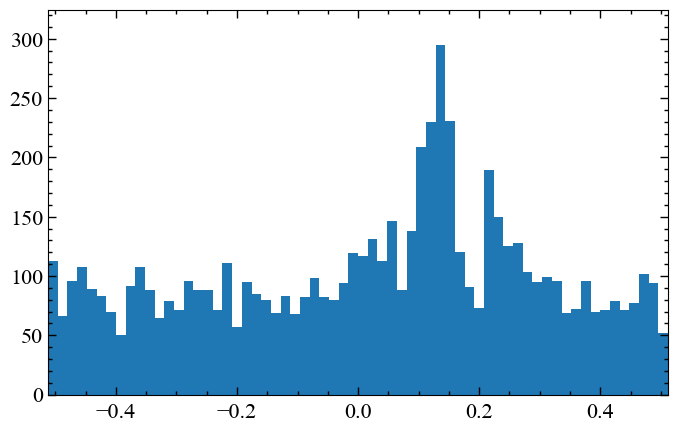

2020-07-16 22:57:39.947491


In [20]:
plt.hist(asim_tus,np.arange(-0.512,0.512+binsize,binsize))
plt.show()
T0 = datetime.fromisoformat('2020-07-16T22:57:40.634') + timedelta(seconds=tlagg_asim)
print(T0)

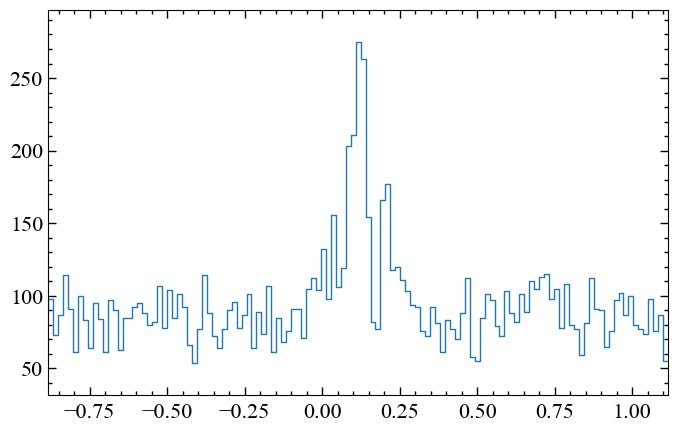

In [22]:
binsize = 0.016
tus_asim = asimData['tus'].to_numpy()
bins=np.round(np.arange(min(tus_asim), max(tus_asim) + binsize, binsize),3)
counts, edges = np.histogram(tus_asim, bins=bins)
Ti, Tf = edges[:-1], edges[1:]
df_export = pd.DataFrame({'Ti':Ti, 'Tf':Tf, 'Counts': counts})
df_export.to_csv(f'/Users/andreas/phys/master/GRB/xspec/ASIM/light_curves/GRB20716C_HED_{binsize*1e3:.0f}ms',index_label=False,index=False)
plt.step(edges[:-1],counts)
plt.show()

In [ ]:
kw_filename = "GRB200716C_16ms.txt"
kw_file = kw_lc_path + kw_filename

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)


i_stop_kw = np.searchsorted(kw_bin_lo,0.512)

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G1+G2+G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()


bins_200716C = np.append(np.round(kw_lc.bin_lo,3),kw_lc.bin_hi[-1])

In [ ]:
GRB_id = "GRB200716C"
bn='bn200716957' # GRB id for Fermi
data_dir = path_FERMI_dir + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 196.01,29.644  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))

In [ ]:
unit = all_dets[idx_sort_angsep][7] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_b0 = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_b0 = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_b0 = TTE.open(fn_tte_b0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte_b0.to_phaii(bin_by_time,binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,4e4)
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (asim_edges[0],asim_edges[-1])
lcplot.ax.set_title(f'GRB200716C FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
#plt.savefig(fname='/Users/andreas/phys/master/GRB/pyplots/GRB211211A_FERMI_LC.png')
plt.show()

In [ ]:
fermi_tus_b0 = tte_b0.data.time-0.1834
i_fermi_b0, j_fermi_b0 = np.searchsorted(fermi_tus_b0,-0.512),np.searchsorted(fermi_tus_b0,0.512)
fermi_tus_b0 = fermi_tus_b0[i_fermi_b0:j_fermi_b0]
hist_fermi_b0 = np.histogram(fermi_tus_b0,bins_200716C)
fermi_counts_b0,fermi_edges_b0 = hist_fermi_b0[0],hist_fermi_b0[1]
plt.step(fermi_edges_b0[:-1],fermi_counts_b0)
plt.show()

In [ ]:
unit = all_dets[idx_sort_angsep][0] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_naI = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_naI = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_naI = TTE.open(fn_tte_naI)

fermi_tus_naI = tte_naI.data.time-0.1834
i_fermi_naI, j_fermi_naI = np.searchsorted(fermi_tus_naI,-0.512),np.searchsorted(fermi_tus_naI,0.512)
fermi_tus_naI = fermi_tus_naI[i_fermi_naI:j_fermi_naI]
hist_fermi_naI = np.histogram(fermi_tus_naI,bins_200716C)
fermi_counts_naI,fermi_edges_naI = hist_fermi_naI[0],hist_fermi_naI[1]
plt.step(fermi_edges_naI[:-1],fermi_counts_naI)
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))

intervals = [0.00,0.256]

ax_height = 1 / 4
ax_width = 0.27

ax1 = fig.add_axes([0.1, 1 - ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 200))
ax2 = fig.add_axes([0.1, 1 - 2 * ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 350))
ax3 = fig.add_axes([0.1, 1 - 3 * ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 300))
ax4 = fig.add_axes([0.1, 1 - 4 * ax_height, ax_width, ax_height], ylim=(0, 200))


ax1.step(x=kw_lc.bin_lo,y=kw_lc.counts,where='pre',label='KW\nG1,G2,G3',color='black')
ax1.set_yticks([0,50,100,150])
ax1.set_ylabel(f'cnts  /  16 ms')
ax1.vlines(x=intervals[0],ymin=0,ymax=250,color='black',linestyle='--')
ax1.vlines(x=intervals[1],ymin=0,ymax=250,color='black',linestyle='--')
#----------------------------------------------------------------------------------
hist = np.histogram(asim_tus,bins=bins_200716C)
asim_counts, asim_edges = hist[0],hist[1]
ax2.step(asim_edges[:-1],asim_counts,label='HED',color='black')
ax2.set_yticks([0,100,200,300])
ax2.set_ylabel(f'cnts  /  16 ms')
ax2.vlines(x=intervals[0],ymin=0,ymax=450,color='black',linestyle='--')
ax2.vlines(x=intervals[1],ymin=0,ymax=450,color='black',linestyle='--')
#---------------------------------------------------------------------------------
ax3.step(fermi_edges_b0[:-1],fermi_counts_b0,label='FERMI BG0. bak',color='black')
ax3.set_yticks([0,100,150,200,250])
ax3.set_ylabel(f'cnts  / 16 ms')
ax3.vlines(x=intervals[0],ymin=0,ymax=300,color='black',linestyle='--')
ax3.vlines(x=intervals[1],ymin=0,ymax=300,color='black',linestyle='--')
#-------------------------------------------------------------------------------
ax4.step(fermi_edges_naI[:-1],fermi_counts_naI,label='FERMI NaI. bak',color='black')
ax4.set_yticks([0,50,100,150])
ax4.set_ylabel(f'cnts  / 16 ms')
ax4.vlines(x=intervals[0],ymin=0,ymax=200,color='black',linestyle='--')
ax4.vlines(x=intervals[1],ymin=0,ymax=200,color='black',linestyle='--')
#-----------------------------------------------------------------------------

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend()
ax4.legend()

plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 200716C',ha='center',va='top',x=0.232,y=1.02)
plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/stacked_LC/GRB200716C.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()

# GRB 201227A

In [23]:
bins_201227A = np.arange(-0.512,0.512,0.002)
binsize=0.002
tlagg_asim = -0.531
T0_asim = datetime.fromisoformat('2020-12-27T15:14:06.853667') + timedelta(seconds=-0.531)
print(T0_asim)

2020-12-27 15:14:06.322667


In [24]:
asimData = pd.read_csv(path_andrey + 'GRB201227A.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
asimData.head()

,tus,dau,det,typ,erg
0,-1.000611,0,1,0,27
1,-1.000611,2,1,0,44
2,-1.000221,0,2,0,1805
3,-1.000221,1,0,0,1595
4,-0.999945,2,1,0,167


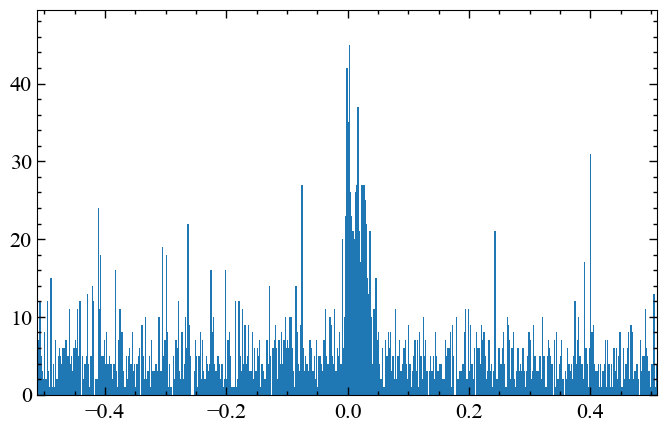

In [25]:
plt.hist(asimData['tus'].to_numpy(),bins=bins_201227A)
plt.show()

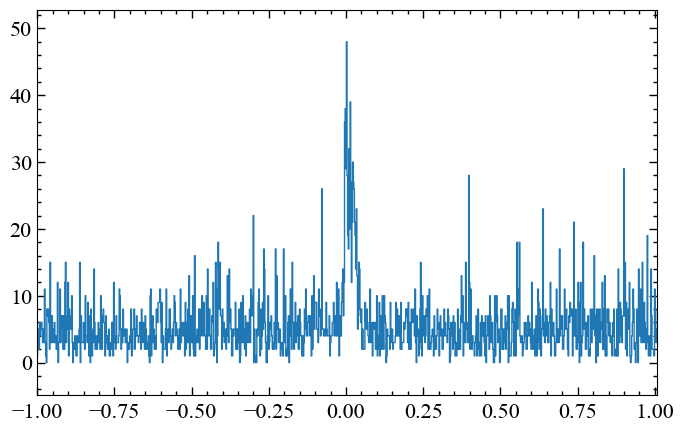

In [27]:
binsize = 0.002
tus_asim = asimData['tus'].to_numpy()
bins=np.round(np.arange(min(tus_asim), max(tus_asim) + binsize, binsize),3)
counts, edges = np.histogram(tus_asim, bins=bins)
Ti, Tf = edges[:-1], edges[1:]
df_export = pd.DataFrame({'Ti':Ti, 'Tf':Tf, 'Counts': counts})
df_export.to_csv(f'/Users/andreas/phys/master/GRB/xspec/ASIM/light_curves/GRB201227A_HED_{binsize*1e3:.0f}ms',index_label=False,index=False)
plt.step(edges[:-1],counts)
plt.show()

In [ ]:
#importing KW LC
kw_fn = 'GRB201227A_2ms.txt'
kw_df = pd.read_csv(kw_lc_path+kw_fn,sep='\s+')
kw_bin_hi =kw_df["Tf"].to_numpy(dtype=np.float32)
jx_kw = np.searchsorted(kw_bin_hi,0.512)
kw_df= kw_df.truncate(after=jx_kw)
G1,G2,G3 = kw_df["G1"].to_numpy(dtype=np.float32), kw_df["G2"].to_numpy(dtype=np.float32), kw_df["G3"].to_numpy(dtype=np.float32)
kw_bin_lo,kw_bin_hi =kw_df["Ti"].to_numpy(dtype=np.float32), kw_df["Tf"].to_numpy(dtype=np.float32)
kw_df.head()

In [ ]:
GRB_id = "GRB201227A"
bn='bn201227635' # GRB id for Fermi
data_dir = path_FERMI_dir + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 170.121,-73.613  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))

In [ ]:
unit = all_dets[idx_sort_angsep][2] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_b0 = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_b0 = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_b0 = TTE.open(fn_tte_b0)

i_fermi_b0, j_fermi_b0 = np.searchsorted(tte_b0.data.time,-0.512),np.searchsorted(tte_b0.data.time,1.058)
fermi_tus_b0 = tte_b0.data.time[i_fermi_b0:j_fermi_b0] - 0.004 #tlagg
hist_fermi_b0 = np.histogram(fermi_tus_b0,bins_201227A)
fermi_counts_b0,fermi_edges_b0 = hist_fermi_b0[0],hist_fermi_b0[1]

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte_b0.to_phaii(bin_by_time,binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,4e4)
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (asim_edges[0],asim_edges[-1])
lcplot.ax.set_title(f'GRB181222B FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
plt.show()

In [ ]:
unit = all_dets[idx_sort_angsep][0] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_naI = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_naI = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_naI = TTE.open(fn_tte_naI)

i_fermi_naI, j_fermi_naI = np.searchsorted(tte_naI.data.time,-0.512),np.searchsorted(tte_naI.data.time,1.058)
fermi_tus_naI = tte_naI.data.time[i_fermi_naI:j_fermi_naI] - 0.004 #tlagg
hist_fermi_naI = np.histogram(fermi_tus_naI,bins_201227A)
fermi_counts_naI,fermi_edges_naI = hist_fermi_naI[0],hist_fermi_naI[1]
plt.step(fermi_edges_naI[:-1],fermi_counts_naI)
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))

binsize=0.002
intervals = [[0.0,0.064]]

ax_height = 1 / 4
ax_width = 0.27

ax1 = fig.add_axes([0.1, 1 - ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 100))
ax2 = fig.add_axes([0.1, 1 - 2 * ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 50))
ax3 = fig.add_axes([0.1, 1 - 3 * ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 75))
ax4 = fig.add_axes([0.1, 1 - 4 * ax_height, ax_width, ax_height], ylim=(0, 50))


# set the yticks for each subplot

ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])

kw_counts = G1+G2+G3
ax1.step(x=kw_bin_lo[:-1],y=kw_counts[:-1],where='pre',label='KW\nG1,G2,G3',color='black')
ax1.set_yticks([0,50,100])
ax1.set_ylabel(f'cnts  /  {round(binsize*1e3)} ms')
ax1.vlines(x=intervals[0][0],ymin=0,ymax=100,color='black',linestyle='--')
ax1.vlines(x=intervals[0][1],ymin=0,ymax=100,color='black',linestyle='--')
#----------------------------------------------------------------------------------
hist = np.histogram(asimData['tus'].to_numpy(),bins_201227A)
asim_counts, asim_edges = hist[0],hist[1]
ax2.step(np.round(asim_edges[:-1],3),asim_counts,label='HED',color='black')
ax2.set_yticks([0,25])
ax2.set_ylabel(f'cnts  /  {round(binsize*1e3)} ms')
ax2.vlines(x=intervals[0][0],ymin=0,ymax=50,color='black',linestyle='--')
ax2.vlines(x=intervals[0][1],ymin=0,ymax=50,color='black',linestyle='--')

#---------------------------------------------------------------------------------
ax3.step(fermi_edges_b0[:-1],fermi_counts_b0,label='Fermi BGO',color='black')
ax3.set_yticks([0,25,50])
ax3.set_ylabel(f'cnts  /  {round(binsize*1e3)} ms')
ax3.vlines(x=intervals[0][0],ymin=0,ymax=75,color='black',linestyle='--')
ax3.vlines(x=intervals[0][1],ymin=0,ymax=75,color='black',linestyle='--')
#-------------------------------------------------------------------------------
ax4.step(fermi_edges_naI[:-1],fermi_counts_naI,label='Fermi NaI',color='black')
ax4.set_yticks([0,10,20,30])
ax4.set_ylabel(f'cnts  /  {round(binsize*1e3)} ms')
ax4.vlines(x=intervals[0][0],ymin=0,ymax=50,color='black',linestyle='--')
ax4.vlines(x=intervals[0][1],ymin=0,ymax=50,color='black',linestyle='--')
#-----------------------------------------------------------------------------

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 201227A',ha='center',va='top',x=0.232,y=1.02)
plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/stacked_LC/GRB201227A.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()

# GRB 210424B

# GRB 210619B

In [24]:
binsize=0.016
tlagg_asim = -0.584
asimData = pd.read_csv(path_andrey + 'GRB210619B.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
asim_tus = asimData['tus'].to_numpy()
asimData.head()

,tus,dau,det,typ,erg
0,-1.009385,2,1,0,34
1,-1.009179,1,2,0,67
2,-1.009071,3,0,0,2037
3,-1.009071,0,2,0,27
4,-1.009071,1,2,0,1595


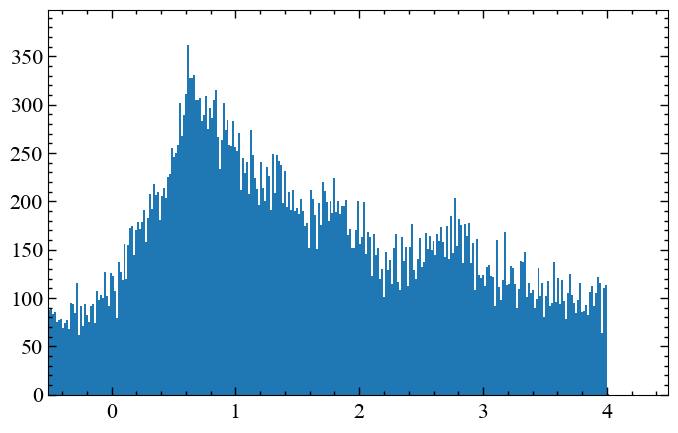

2021-06-19 23:59:24.910265


In [25]:
plt.hist(asim_tus,np.arange(-0.512,4.5,binsize))
plt.show()
T0 = datetime.fromisoformat('2021-06-19T23:59:25.494265') + timedelta(seconds=tlagg_asim)
print(T0)

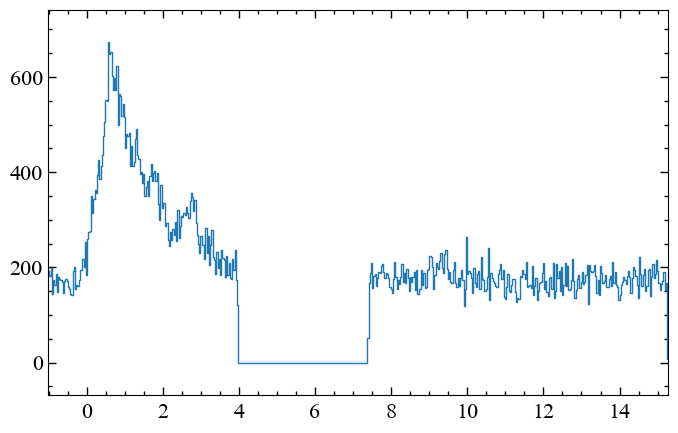

In [29]:
binsize = 0.032
tus_asim = asimData['tus'].to_numpy()
bins=np.round(np.arange(min(tus_asim), max(tus_asim) + binsize, binsize),3)
counts, edges = np.histogram(tus_asim, bins=bins)
Ti, Tf = edges[:-1], edges[1:]
df_export = pd.DataFrame({'Ti':Ti, 'Tf':Tf, 'Counts': counts})
df_export.to_csv(f'/Users/andreas/phys/master/GRB/xspec/ASIM/light_curves/GRB210619B_HED_{binsize*1e3:.0f}ms',index_label=False,index=False)
plt.step(edges[:-1],counts)
plt.show()

In [ ]:
kw_filename = "GRB210619B_16ms.txt"
kw_file = kw_lc_path + kw_filename

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)


i_stop_kw = np.searchsorted(kw_bin_lo,4.5)

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G1+G2+G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()


bins_210619B = np.append(np.round(kw_lc.bin_lo,3),kw_lc.bin_hi[-1])

In [ ]:
GRB_id = "GRB210619BC"
bn='bn210619999' # GRB id for Fermi
data_dir = path_FERMI_dir + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 319.716,33.850  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))

In [ ]:
unit = all_dets[idx_sort_angsep][4] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_b0 = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_b0 = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_b0 = TTE.open(fn_tte_b0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte_b0.to_phaii(bin_by_time,binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,4e4)
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-0.512,4.5)
lcplot.ax.set_title(f'GRB210619B FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
#plt.savefig(fname='/Users/andreas/phys/master/GRB/pyplots/GRB211211A_FERMI_LC.png')
plt.show()

In [ ]:
fermi_tus_b0 = tte_b0.data.time+0.0426
i_fermi_b0, j_fermi_b0 = np.searchsorted(fermi_tus_b0,-0.512),np.searchsorted(fermi_tus_b0,4.5)
fermi_tus_b0 = fermi_tus_b0[i_fermi_b0:j_fermi_b0]
hist_fermi_b0 = np.histogram(fermi_tus_b0,bins_210619B)
fermi_counts_b0,fermi_edges_b0 = hist_fermi_b0[0],hist_fermi_b0[1]
plt.step(fermi_edges_b0[:-1],fermi_counts_b0)
plt.show()

In [ ]:
unit = all_dets[idx_sort_angsep][0] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_naI = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_naI = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_naI = TTE.open(fn_tte_naI)

fermi_tus_naI = tte_naI.data.time+0.0426
i_fermi_naI, j_fermi_naI = np.searchsorted(fermi_tus_naI,-0.512),np.searchsorted(fermi_tus_naI,4.5)
fermi_tus_naI = fermi_tus_naI[i_fermi_naI:j_fermi_naI]
hist_fermi_naI = np.histogram(fermi_tus_naI,bins_210619B)
fermi_counts_naI,fermi_edges_naI = hist_fermi_naI[0],hist_fermi_naI[1]
plt.step(fermi_edges_naI[:-1],fermi_counts_naI)
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))

intervals = [[0.512,0.768],[0.0,2.048]]

ax_height = 1 / 4
ax_width = 0.27

ax1 = fig.add_axes([0.1, 1 - ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 600))
ax2 = fig.add_axes([0.1, 1 - 2 * ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 400))
ax3 = fig.add_axes([0.1, 1 - 3 * ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 400))
ax4 = fig.add_axes([0.1, 1 - 4 * ax_height, ax_width, ax_height], ylim=(0, 500))


ax1.step(x=kw_lc.bin_lo,y=kw_lc.counts,where='pre',label='KW\nG1,G2,G3',color='black')
ax1.set_yticks([0,200,400])
ax1.set_ylabel(f'cnts  /  16 ms')
ax1.vlines(x=intervals[0][0],ymin=0,ymax=600,color='black',linestyle='--')
ax1.vlines(x=intervals[0][1],ymin=0,ymax=600,color='black',linestyle='--')
ax1.vlines(x=intervals[1][0],ymin=0,ymax=600,color='red',linestyle='--')
ax1.vlines(x=intervals[1][1],ymin=0,ymax=600,color='red',linestyle='--')
#----------------------------------------------------------------------------------
hist = np.histogram(asim_tus,bins=bins_210619B)
asim_counts, asim_edges = hist[0],hist[1]
ax2.step(asim_edges[:-1],asim_counts,label='HED',color='black')
ax2.set_yticks([0,100,200,300])
ax2.set_ylabel(f'cnts  /  16 ms')
ax2.vlines(x=intervals[0][0],ymin=0,ymax=400,color='black',linestyle='--')
ax2.vlines(x=intervals[0][1],ymin=0,ymax=400,color='black',linestyle='--')
ax2.vlines(x=intervals[1][0],ymin=0,ymax=400,color='red',linestyle='--')
ax2.vlines(x=intervals[1][1],ymin=0,ymax=400,color='red',linestyle='--')
#---------------------------------------------------------------------------------
ax3.step(fermi_edges_b0[:-1],fermi_counts_b0,label='FERMI BG0',color='black')
ax3.set_yticks([0,100,200,300])
ax3.set_ylabel(f'cnts  / 16 ms')
ax3.vlines(x=intervals[0][0],ymin=0,ymax=400,color='black',linestyle='--')
ax3.vlines(x=intervals[0][1],ymin=0,ymax=400,color='black',linestyle='--')
ax3.vlines(x=intervals[1][0],ymin=0,ymax=400,color='red',linestyle='--')
ax3.vlines(x=intervals[1][1],ymin=0,ymax=400,color='red',linestyle='--')
#-------------------------------------------------------------------------------
ax4.step(fermi_edges_naI[:-1],fermi_counts_naI,label='FERMI NaI',color='black')
ax4.set_yticks([0,100,200,300,400])
ax4.set_ylabel(f'cnts  / 16 ms')
ax4.vlines(x=intervals[0][0],ymin=0,ymax=500,color='black',linestyle='--')
ax4.vlines(x=intervals[0][1],ymin=0,ymax=500,color='black',linestyle='--')
ax4.vlines(x=intervals[1][0],ymin=0,ymax=500,color='red',linestyle='--')
ax4.vlines(x=intervals[1][1],ymin=0,ymax=500,color='red',linestyle='--')
#-----------------------------------------------------------------------------

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend()
ax4.legend()

plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 210619B',ha='center',va='top',x=0.232,y=1.02)
plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/stacked_LC/GRB210619B.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()

# GRB 211211A

In [10]:
binsize=0.064
bins_211211A = np.arange(-0.512,8.576,binsize)
tlagg_asim = +1.728
asimData = pd.read_csv(path_andrey + 'GRB211211A.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
asim_tus = asimData['tus'].to_numpy()
asimData.head()

,tus,dau,det,typ,erg
0,0.768000,1,1,0,82
1,0.768216,0,2,0,2030
2,0.768216,1,1,0,1666
3,0.768216,3,1,0,600
4,0.768216,0,0,0,629


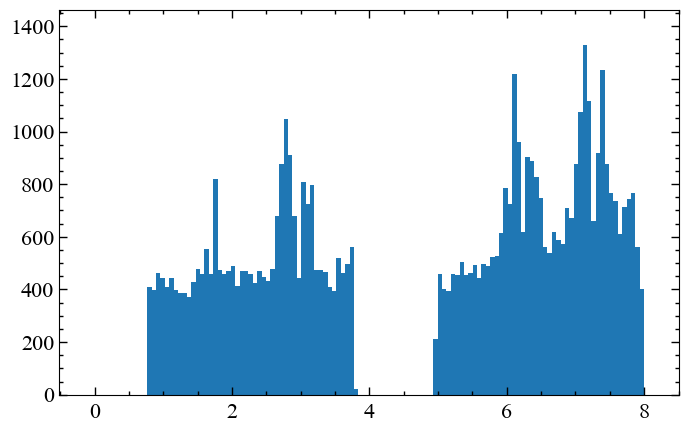

2021-12-11 13:10:03.099968


In [11]:
plt.hist(asim_tus,bins_211211A)
plt.show()
T0 = datetime.fromisoformat('2021-12-11T13:10:01.371968') + timedelta(seconds=tlagg_asim)
print(T0)

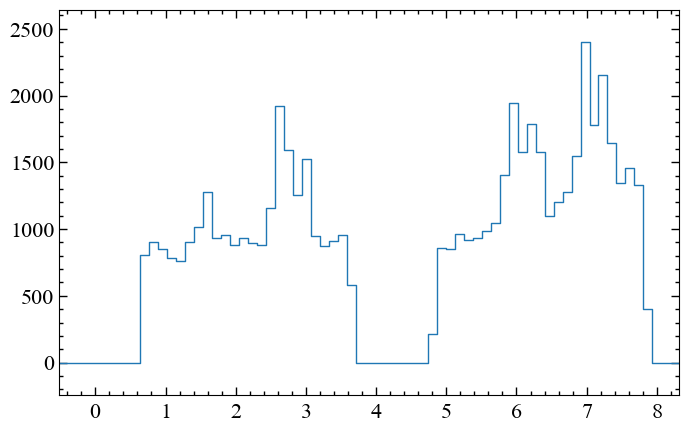

In [23]:
binsize = 0.128
tus_asim = asimData['tus'].to_numpy()
bins = np.arange(-0.512,8.576,binsize)
counts, edges = np.histogram(tus_asim, bins=bins)
Ti, Tf = edges[:-1], edges[1:]
df_export = pd.DataFrame({'Ti':Ti, 'Tf':Tf, 'Counts': counts})
df_export.to_csv(f'/Users/andreas/phys/master/GRB/xspec/ASIM/light_curves/GRB211211A_HED_{binsize*1e3:.0f}ms',index_label=False,index=False)
plt.step(edges[:-1],counts)
plt.show()

In [4]:
GRB_id = "GRB211211A"
bn='bn211211549' # GRB id for Fermi
data_dir = path_FERMI_dir + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 212.271, 27.884  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))

glg_trigdat_all_bn211211549_v01.fit
660921004.65092
['n2', 'na']
n2 28.937
na 49.853
n1 73.268
n5 75.591
b0 78.594
n9 84.885
n0 94.495
b1 101.406
nb 104.725
n3 128.52
n6 128.828
n4 130.309
n7 145.304
n8 149.746


b0


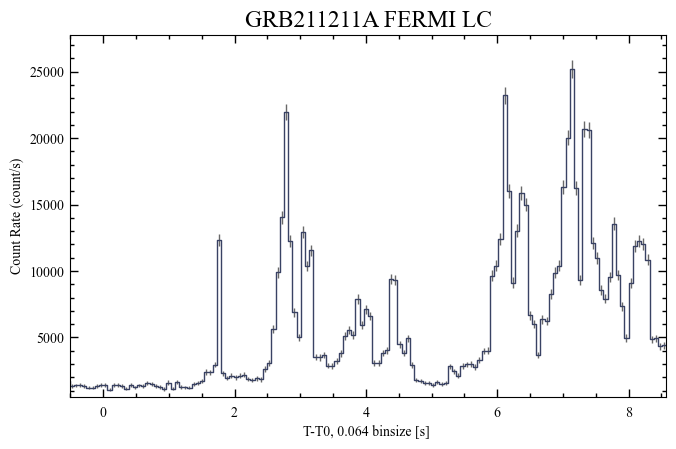

In [5]:
unit = all_dets[idx_sort_angsep][4] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_b0 = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_b0 = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_b0 = TTE.open(fn_tte_b0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte_b0.to_phaii(bin_by_time,binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,4e4)
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-0.512,8.576)
lcplot.ax.set_title(f'GRB211211A FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
#plt.savefig(fname='/Users/andreas/phys/master/GRB/pyplots/GRB211211A_FERMI_LC.png')
plt.show()

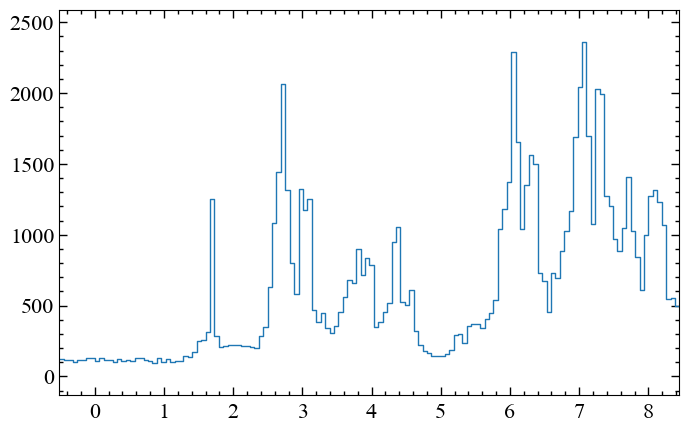

In [6]:
fermi_tus_b0 = tte_b0.data.time
i_fermi_b0, j_fermi_b0 = np.searchsorted(fermi_tus_b0,-0.512),np.searchsorted(fermi_tus_b0,8.576)
fermi_tus_b0 = fermi_tus_b0[i_fermi_b0:j_fermi_b0]
hist_fermi_b0 = np.histogram(fermi_tus_b0,bins_211211A)
fermi_counts_b0,fermi_edges_b0 = hist_fermi_b0[0],hist_fermi_b0[1]
plt.step(fermi_edges_b0[:-1],fermi_counts_b0)
plt.show()

n2


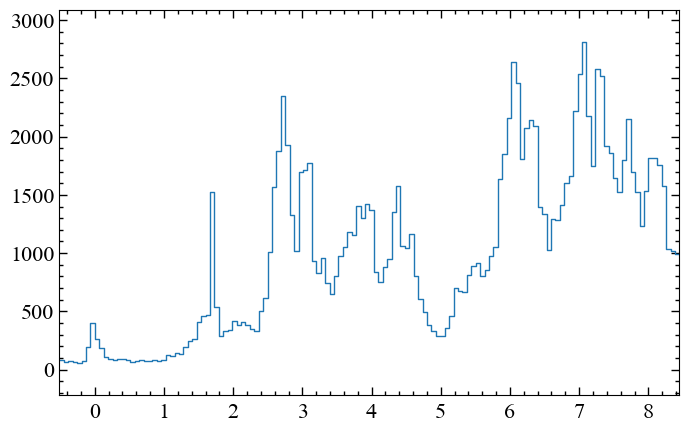

In [7]:
unit = all_dets[idx_sort_angsep][0] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_naI = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_naI = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_naI = TTE.open(fn_tte_naI)

fermi_tus_naI = tte_naI.data.time
i_fermi_naI, j_fermi_naI = np.searchsorted(fermi_tus_naI,-0.512),np.searchsorted(fermi_tus_naI,8.576)
fermi_tus_naI = fermi_tus_naI[i_fermi_naI:j_fermi_naI]
hist_fermi_naI = np.histogram(fermi_tus_naI,bins_211211A)
fermi_counts_naI,fermi_edges_naI = hist_fermi_naI[0],hist_fermi_naI[1]
plt.step(fermi_edges_naI[:-1],fermi_counts_naI)
plt.show()

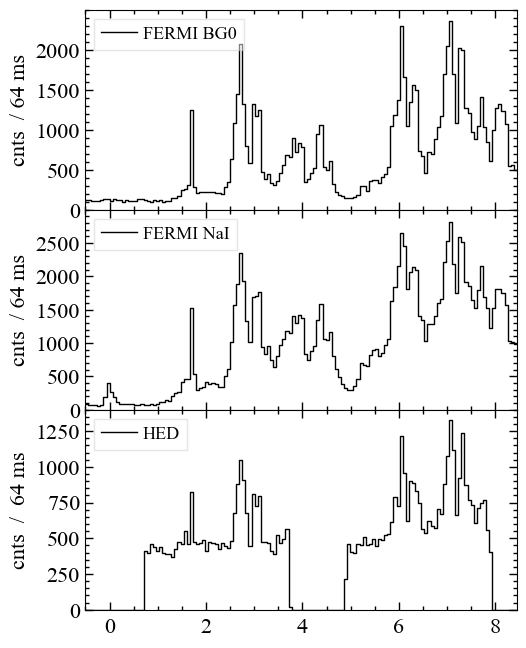

In [8]:
fig = plt.figure(figsize=(16, 8))

ax_height = 1 / 4
ax_width = 0.27

ax1 = fig.add_axes([0.1, 1 - ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 2500))
ax2 = fig.add_axes([0.1, 1 - 2 * ax_height, ax_width, ax_height], xticklabels=[], ylim=(0, 3000))
ax3 = fig.add_axes([0.1, 1 - 3 * ax_height, ax_width, ax_height], ylim=(0, 1400))


#intervals = [(1.5, 2.5),(2.5, 3.5),(3.5, 4.5),(5.824, 6.208), (6.208, 6.464), (6.848, 7.232), (7.232, 7.552)]

# Define colors and labels for each interval
#colors = ['blue', 'green', 'purple', 'cyan', 'magenta', 'orange', 'red']
#labels = ['I', 'II', 'III', 'IV1', 'IV2', 'V1', 'V2']

# Iterate through the intervals and plot vlines with interval labels
#for i, interval in enumerate(intervals):
#    color = colors[i % len(colors)]
#    label = labels[i]
#    ax1.vlines(x=interval[0], ymin=0, ymax=ax1.get_ylim()[1], color=color)
#    ax1.vlines(x=interval[1], ymin=0, ymax=ax1.get_ylim()[1], color=color)
#    ax1.text((interval[0]+interval[1])/2, ax1.get_ylim()[1]*1.05, label, color=color, fontsize=12, ha='center')
    
#    ax2.vlines(x=interval[0], ymin=0, ymax=ax2.get_ylim()[1], color=color)
#    ax2.vlines(x=interval[1], ymin=0, ymax=ax2.get_ylim()[1], color=color)

#    ax3.vlines(x=interval[0], ymin=0, ymax=ax3.get_ylim()[1], color=color)
#    ax3.vlines(x=interval[1], ymin=0, ymax=ax3.get_ylim()[1], color=color)
    
ax1.step(fermi_edges_b0[:-1],fermi_counts_b0,label='FERMI BG0',color='black')
ax1.set_yticks([0,500,1000,1500,2000])
ax1.set_ylabel(f'cnts  / 64 ms')
ax1.legend(loc='upper left')

ax2.step(fermi_edges_naI[:-1],fermi_counts_naI,label='FERMI NaI',color='black')
ax2.set_yticks([0,500,1000,1500,2000,2500])
ax2.set_ylabel(f'cnts  / 64 ms')
ax2.legend(loc='upper left')

hist = np.histogram(asim_tus,bins=bins_211211A)
asim_counts, asim_edges = hist[0],hist[1]
ax3.step(asim_edges[:-1],asim_counts,label='HED',color='black')
ax3.set_yticks([0,250,500,750,1000,1250])
ax3.set_ylabel(f'cnts  /  64 ms')
ax3.legend()

#plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/stacked_LC/GRB211211A_noInterval.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()

# Checking LCs

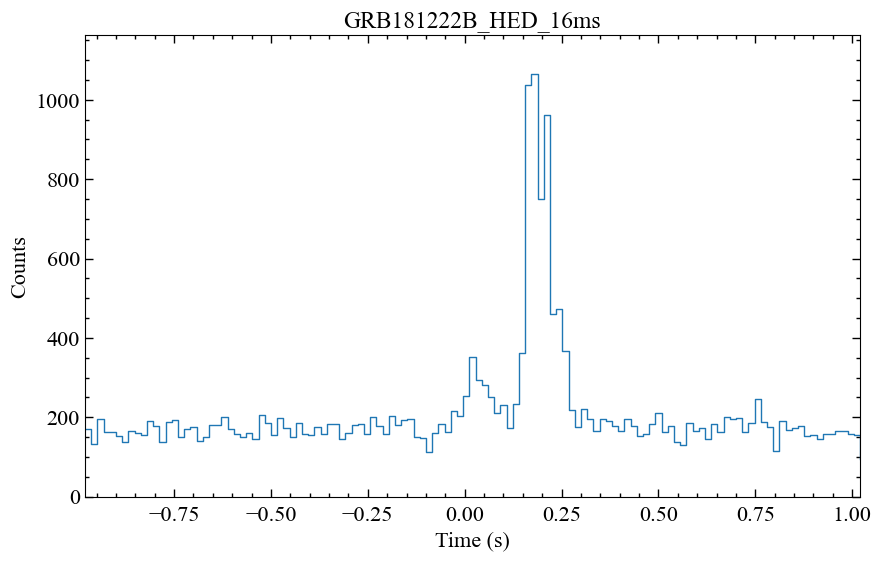

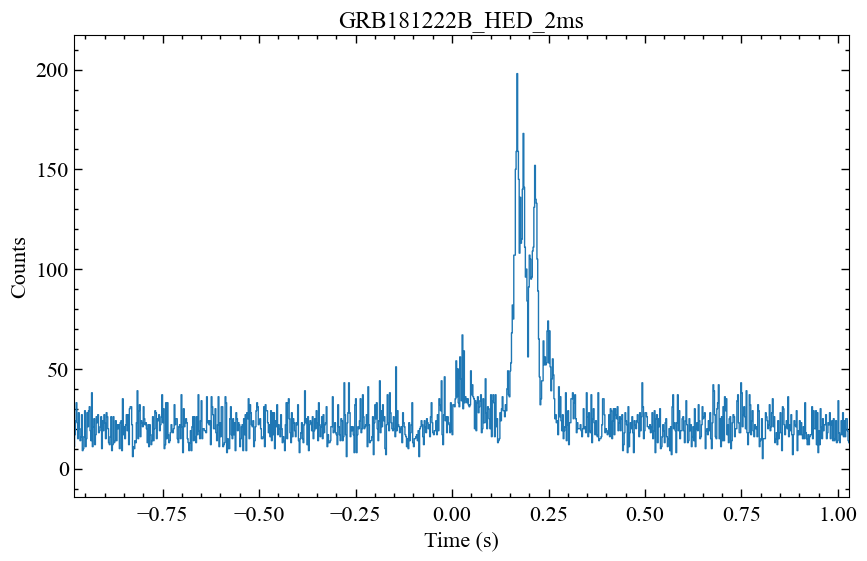

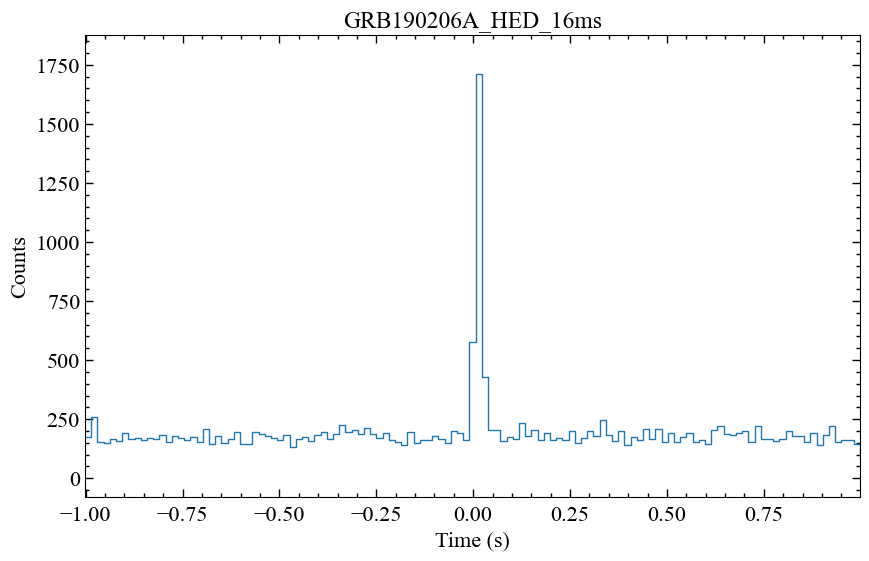

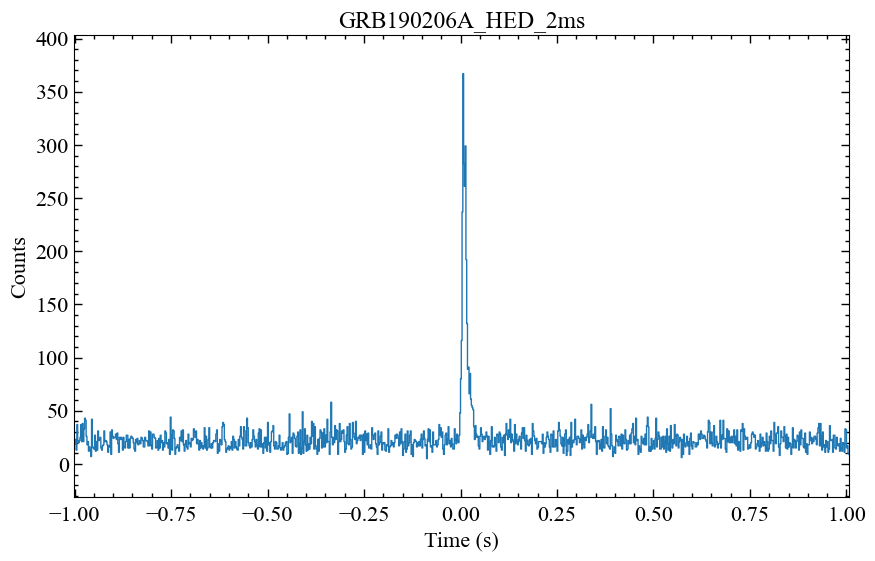

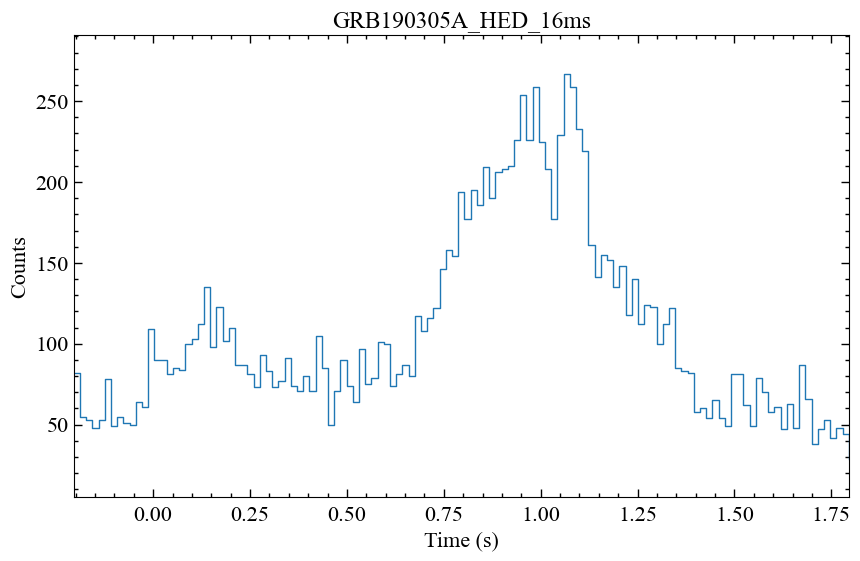

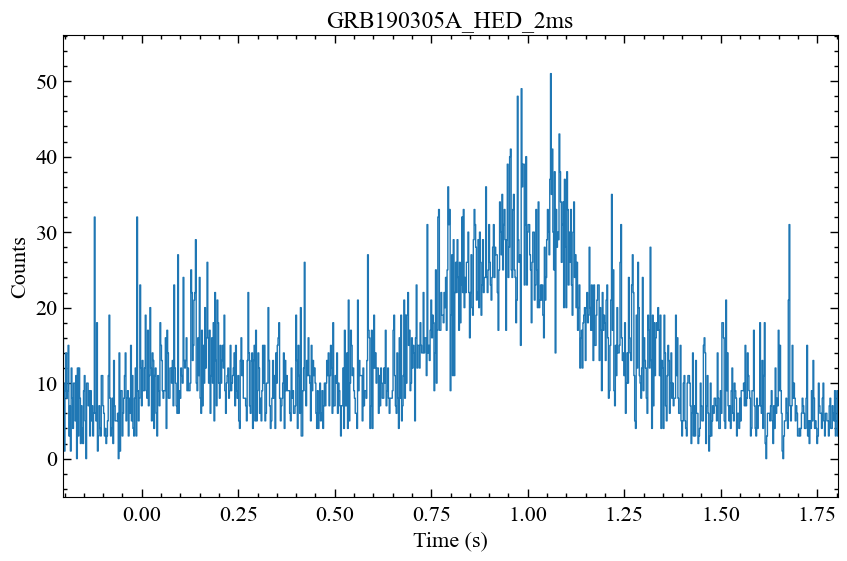

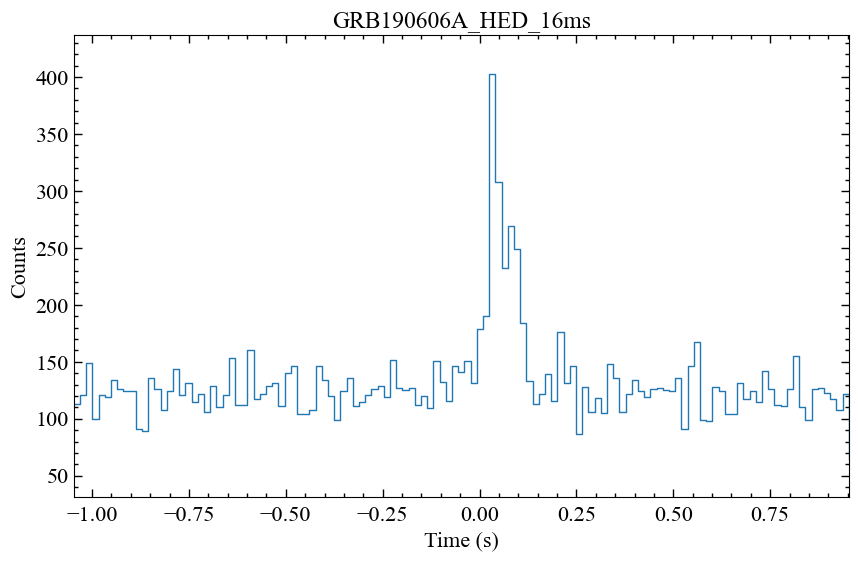

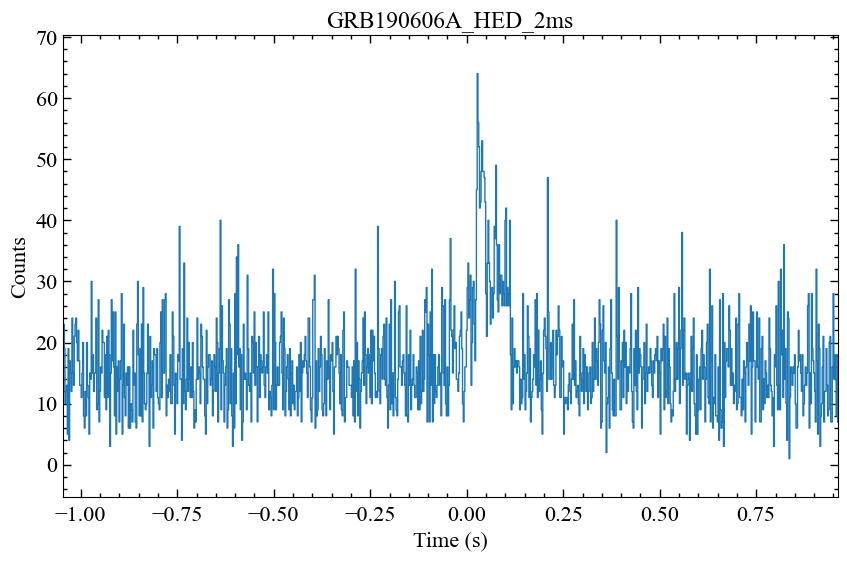

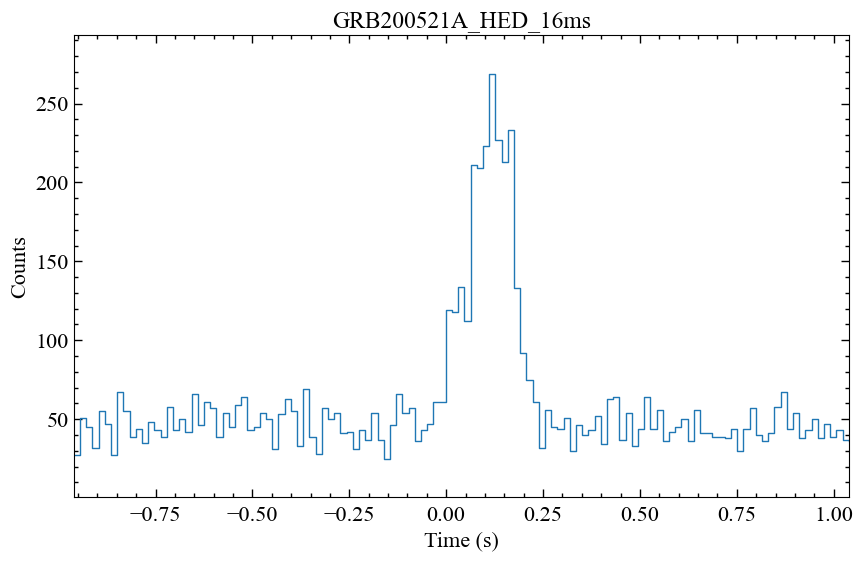

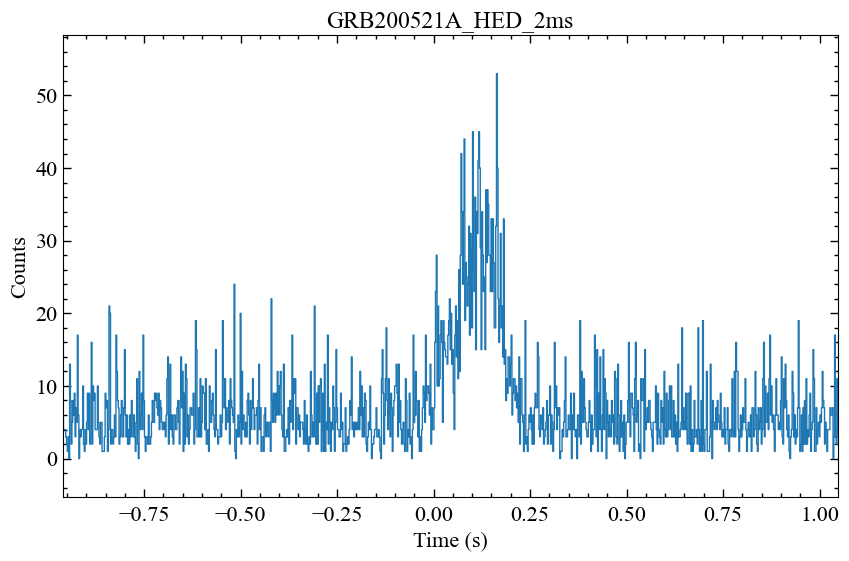

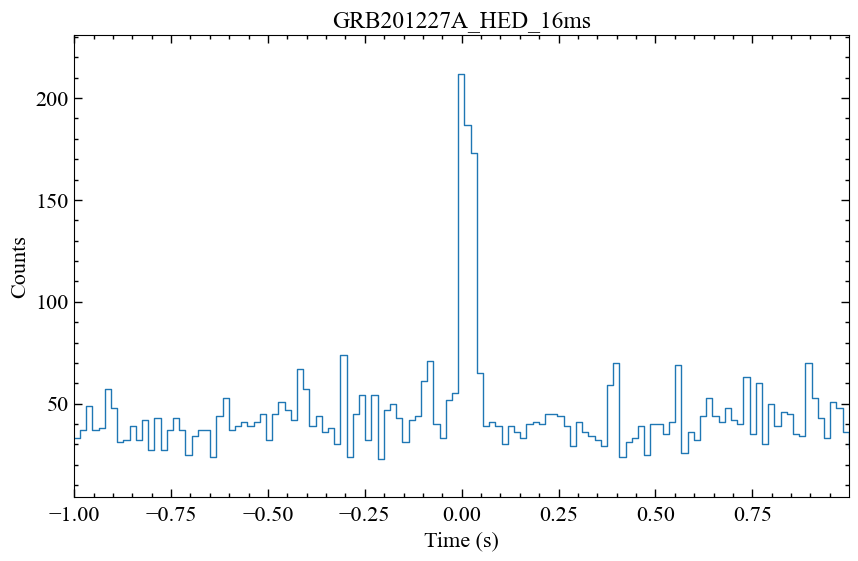

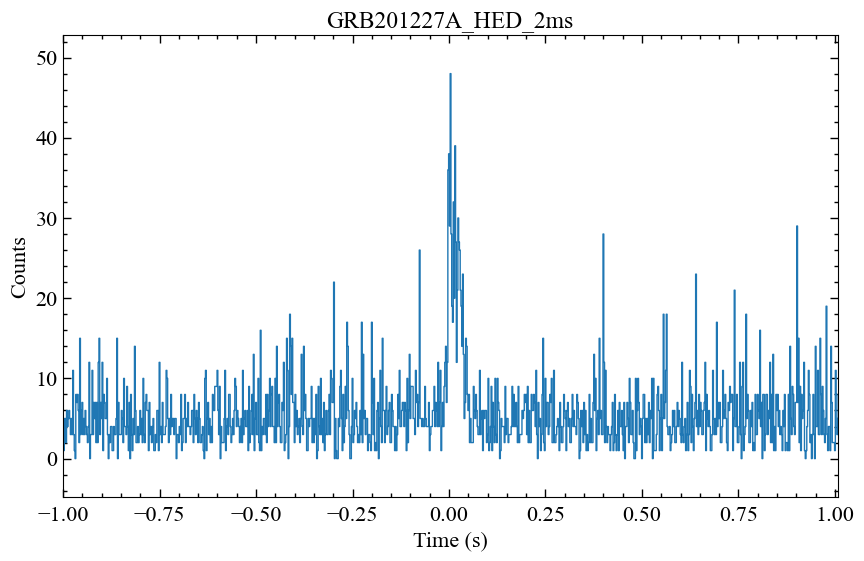

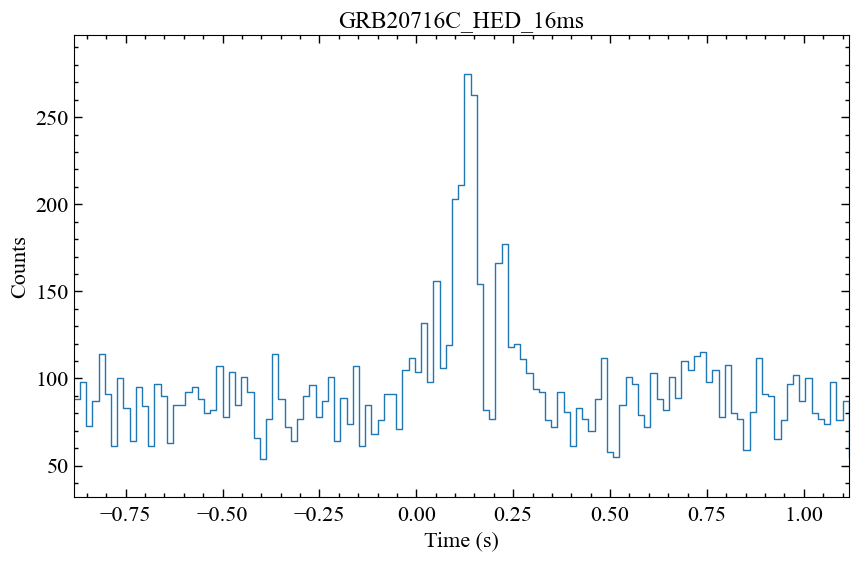

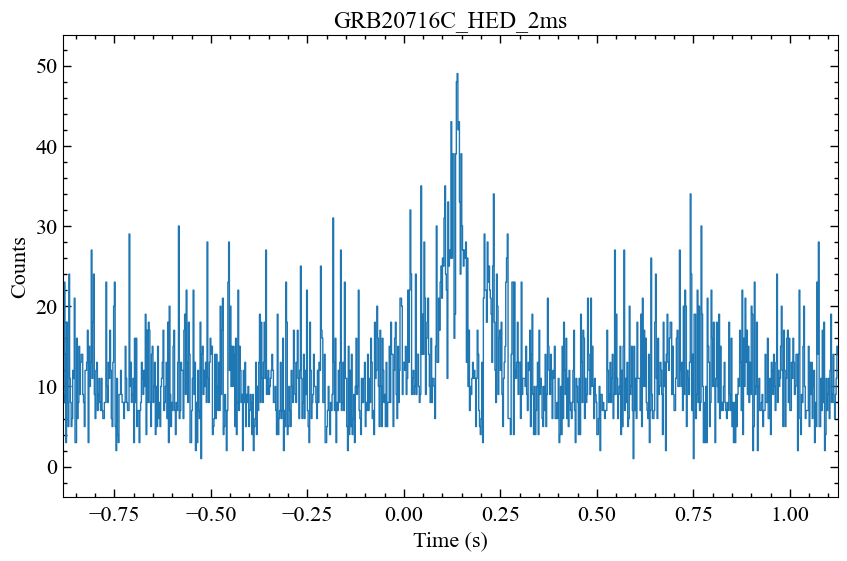

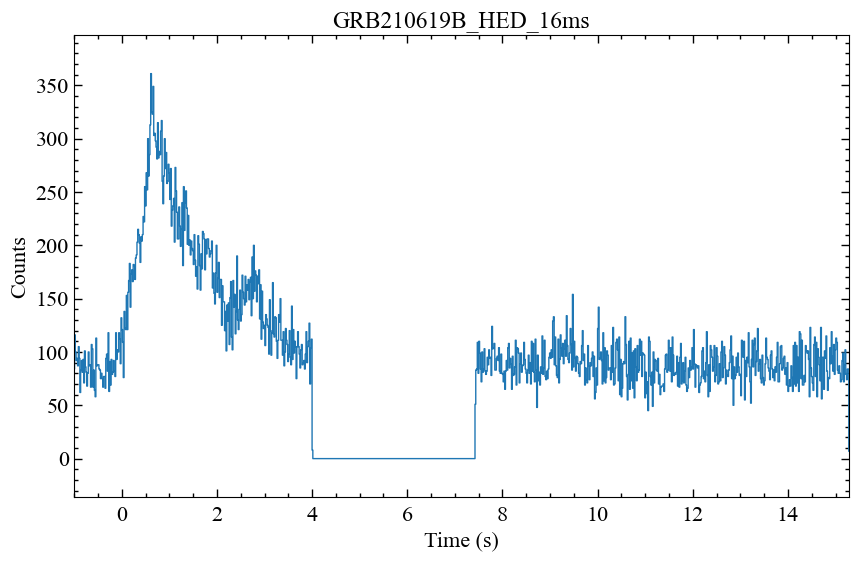

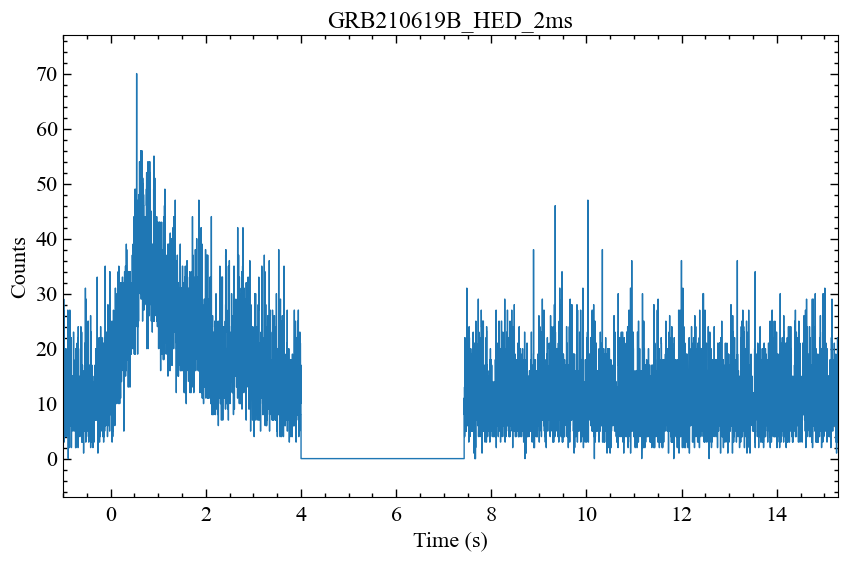

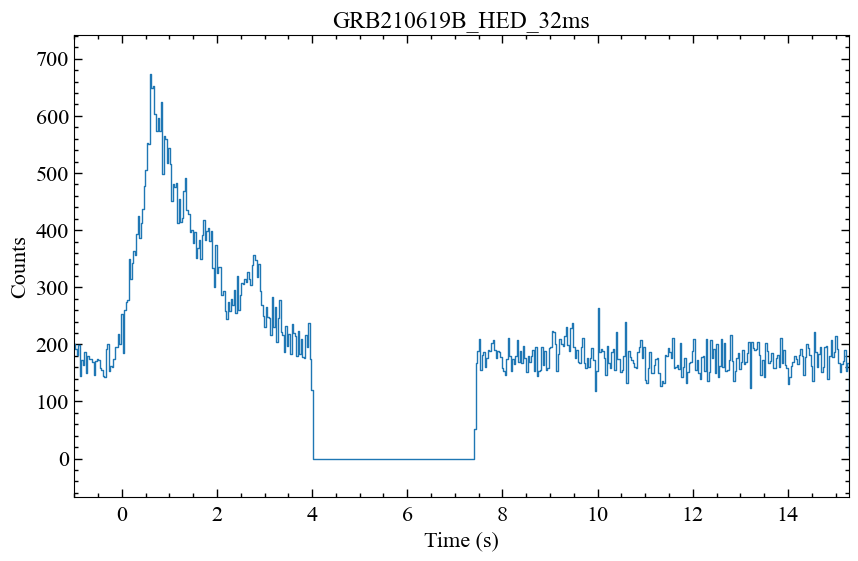

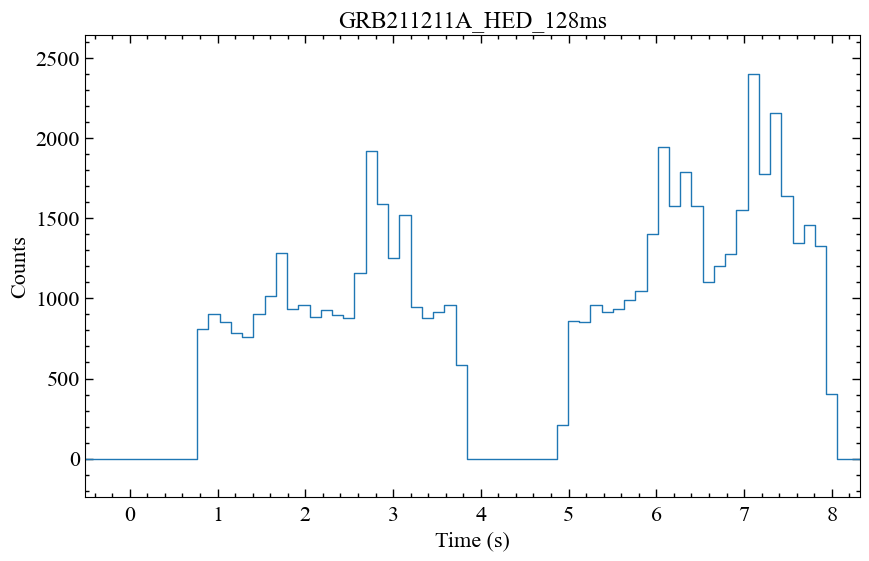

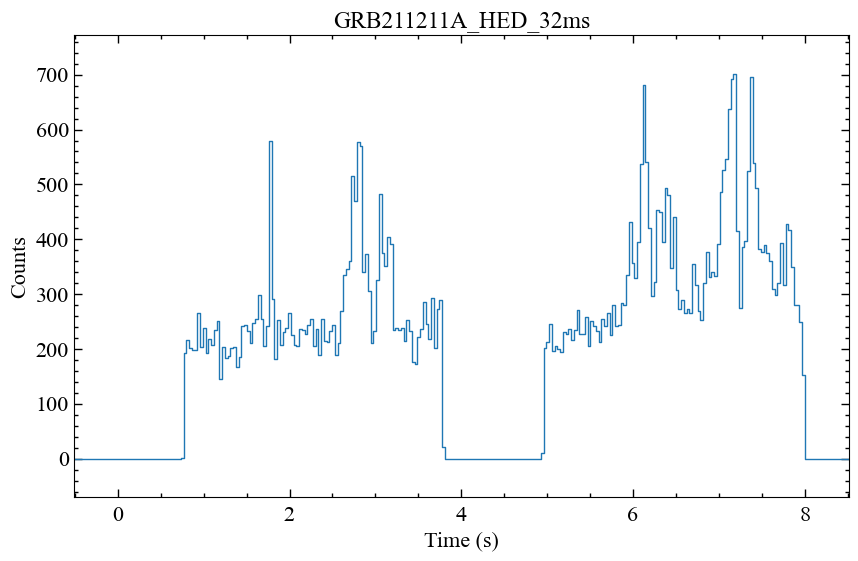

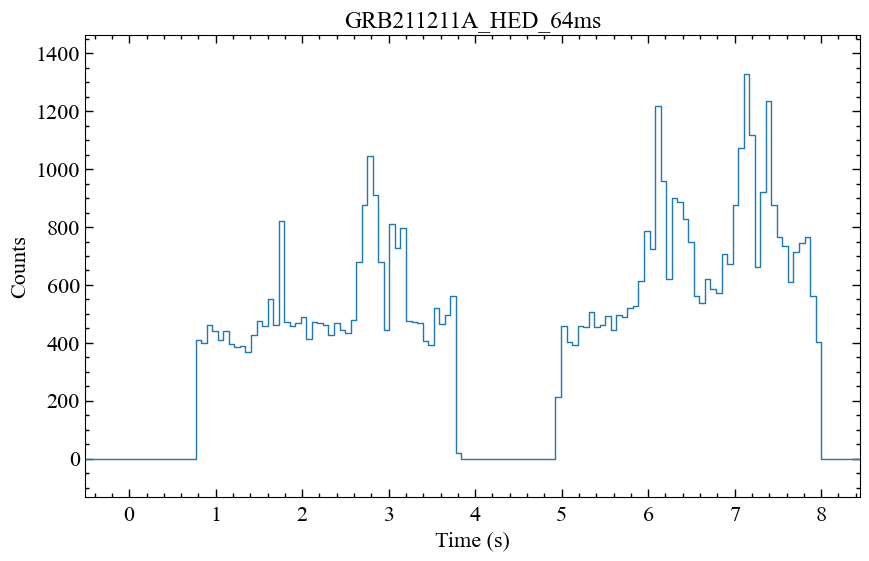

In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directory where the csv files are stored
directory = "/Users/andreas/phys/master/GRB/xspec/ASIM/light_curves/"

filenames = sorted([f for f in os.listdir(directory) if f.startswith("GRB")])

# Iterate over every file in the sorted list
for filename in filenames:
        # Construct the full file path
        filepath = os.path.join(directory, filename)
        
        # Read the csv file into a pandas DataFrame
        df = pd.read_csv(filepath)
        
        # Plot the light curve using Ti as the x-axis and Counts as the y-axis
        plt.figure(figsize=(10, 6))
        plt.step(df['Ti'], df['Counts'], where='post')

        # Set the title of the plot to be the filename
        plt.title(filename)

        # Set the labels for the x and y axes
        plt.xlabel('Time (s)')
        plt.ylabel('Counts')

        # Display the plot
        plt.show()
